[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/romiaprilian7406/sp500-ratio-cluster/blob/main/notebooks/sp500_ratio_cluster_clean.ipynb)

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

# Machine Learning Modules
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Global Configurations

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
plt.style.use('seaborn-v0_8-whitegrid')

# Data Loading

In [3]:
dataset_url = 'https://raw.githubusercontent.com/romiaprilian7406/sp500-ratio-cluster/refs/heads/main/data/sp500_ratclust_dataset.csv'

try:
  df = pd.read_csv(dataset_url)
  print(f"Berhasil connect ke {dataset_url}")
except Exception as e:
  print(f"Gagal connect: {e}")

Berhasil connect ke https://raw.githubusercontent.com/romiaprilian7406/sp500-ratio-cluster/refs/heads/main/data/sp500_ratclust_dataset.csv


# EDA

In [4]:
df_eda = df.copy()

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Fitur numerik yang digunakan ({len(num_cols)}): \n{num_cols}")

Fitur numerik yang digunakan (15): 
['marketCap', 'trailingPE', 'forwardPE', 'priceToBook', 'enterpriseToRevenue', 'returnOnEquity', 'returnOnAssets', 'profitMargins', 'operatingMargins', 'debtToEquity', 'currentRatio', 'quickRatio', 'beta', 'revenueGrowth', 'earningsGrowth']


## info

In [5]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ticker               502 non-null    object 
 1   sector               502 non-null    object 
 2   marketCap            502 non-null    int64  
 3   trailingPE           476 non-null    float64
 4   forwardPE            502 non-null    float64
 5   priceToBook          502 non-null    float64
 6   enterpriseToRevenue  498 non-null    float64
 7   returnOnEquity       473 non-null    float64
 8   returnOnAssets       502 non-null    float64
 9   profitMargins        502 non-null    float64
 10  operatingMargins     502 non-null    float64
 11  debtToEquity         448 non-null    float64
 12  currentRatio         484 non-null    float64
 13  quickRatio           484 non-null    float64
 14  beta                 500 non-null    float64
 15  revenueGrowth        500 non-null    flo

## describe

In [6]:
df_eda.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
marketCap,502.0000,131101968084.1434,437504171119.8301,4089366016.0000,20330273792.0000,38173464576.0000,83729592320.0000,4441136693248.0000
trailingPE,476.0000,38.1264,73.6867,4.5365,17.6599,24.6759,34.1831,1133.5000
forwardPE,502.0000,25.3563,37.8803,-200.6154,13.4439,19.8377,27.0782,503.8125
priceToBook,502.0000,1.4049,53.6780,-945.0509,1.7172,3.1100,6.8826,189.4690
enterpriseToRevenue,498.0000,5.2038,6.3181,-3.4690,2.0457,3.8715,6.4657,109.6230
returnOnEquity,473.0000,0.2538,0.4870,-2.0668,0.0917,0.1541,0.2884,5.6387
returnOnAssets,502.0000,0.0682,0.0592,-0.1549,0.0324,0.0530,0.0885,0.5353
profitMargins,502.0000,0.1398,0.1464,-1.3961,0.0721,0.1306,0.2054,0.7122
operatingMargins,502.0000,0.2169,0.1518,-0.8917,0.1174,0.2008,0.3051,0.9767
debtToEquity,448.0000,140.1476,281.1509,0.5280,39.8290,75.4565,141.3498,4217.2110


## Missing Values

In [7]:
# Hitung jumlah dan persentase missing
missing = df_eda[num_cols].isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if not missing.empty:
    missing_pct = (missing / len(df_eda)) * 100
    missing_df = pd.DataFrame({'Jumlah Hilang': missing, 'Persentase (%)': missing_pct})
    display(missing_df.style.background_gradient(cmap='Reds', subset=['Persentase (%)']).format("{:.2f}"))
else:
    print("Tidak ditemukan missing values")

,Jumlah Hilang,Persentase (%)
earningsGrowth,59.00,11.75
debtToEquity,54.00,10.76
returnOnEquity,29.00,5.78
trailingPE,26.00,5.18
currentRatio,18.00,3.59
quickRatio,18.00,3.59
enterpriseToRevenue,4.00,0.80
beta,2.00,0.40
revenueGrowth,2.00,0.40


## Numeric Feature Distributions

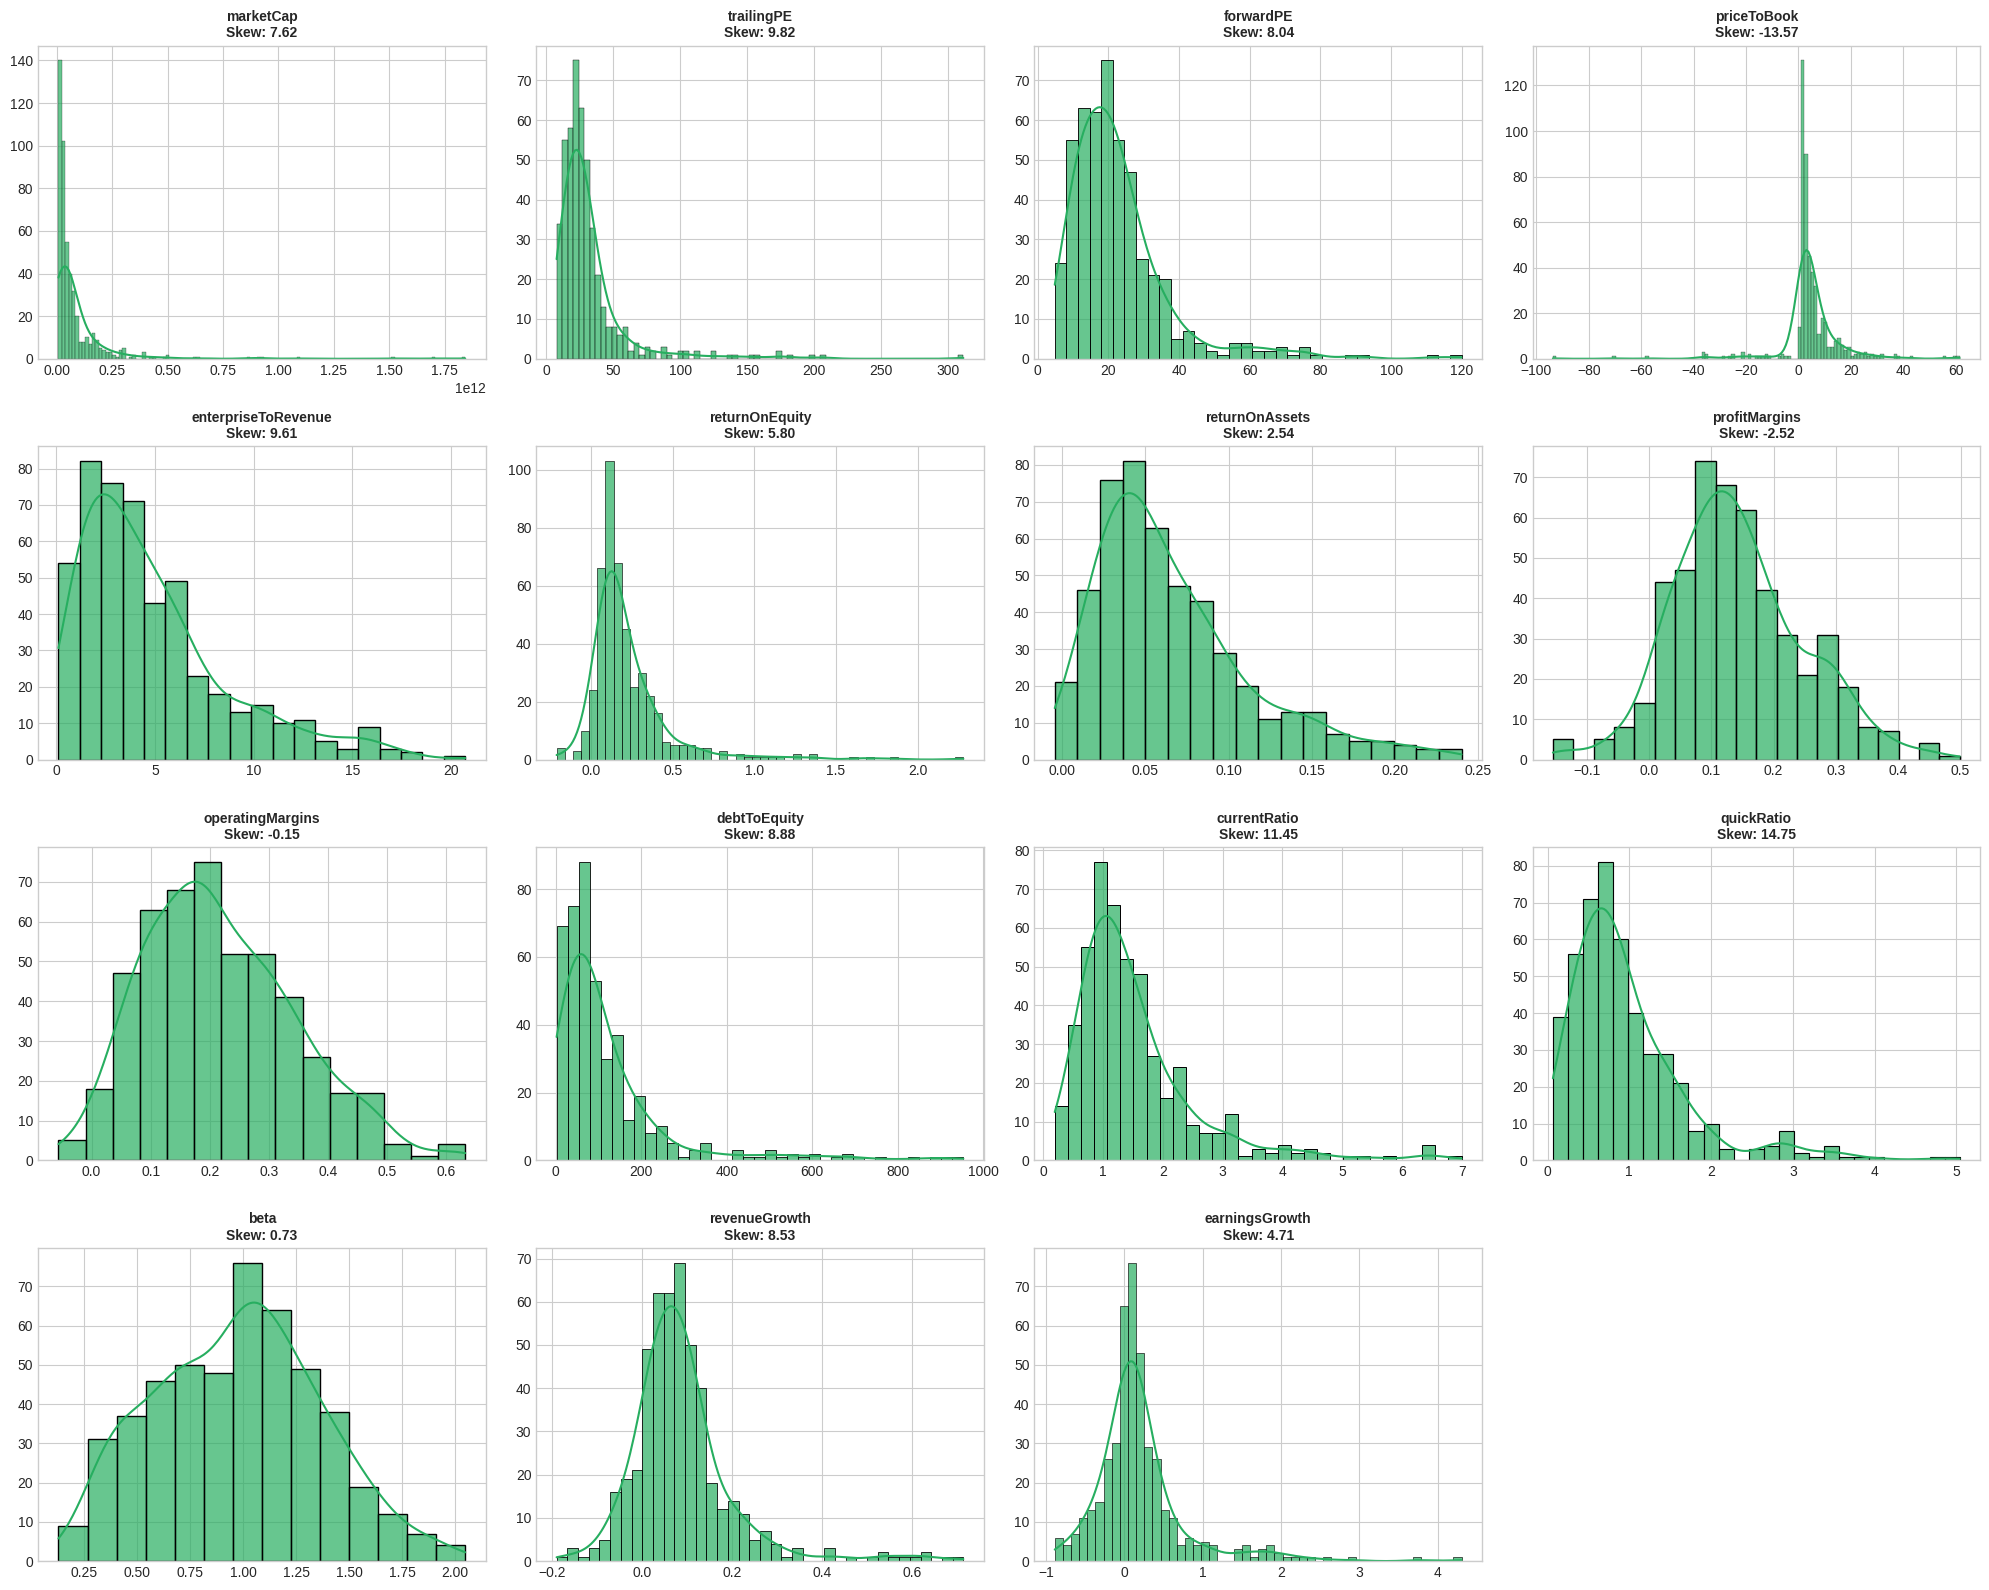

In [8]:
# Setup Grid 4x4 (Untuk 16 Fitur)
n_cols = 4
n_rows = int(np.ceil(len(num_cols) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 16))
axs = axs.flatten()

for i, col in enumerate(num_cols):
    # Filter outlier ekstrem HANYA untuk visualisasi (agar grafik terbaca)
    # Ini tidak menghapus data asli, cuma agar histogramnya tidak gepeng
    data_viz = df_eda[col].dropna()
    q_low, q_high = data_viz.quantile(0.01), data_viz.quantile(0.99)
    data_viz = data_viz[(data_viz >= q_low) & (data_viz <= q_high)]

    sns.histplot(data_viz, kde=True, ax=axs[i], color='#27ae60', alpha=0.7)

    # Hitung Skewness Asli
    skew_val = df_eda[col].skew()
    axs[i].set_title(f'{col}\nSkew: {skew_val:.2f}', fontsize=10, fontweight='bold')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

# Hapus subplot kosong jika ada
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

## Outliers

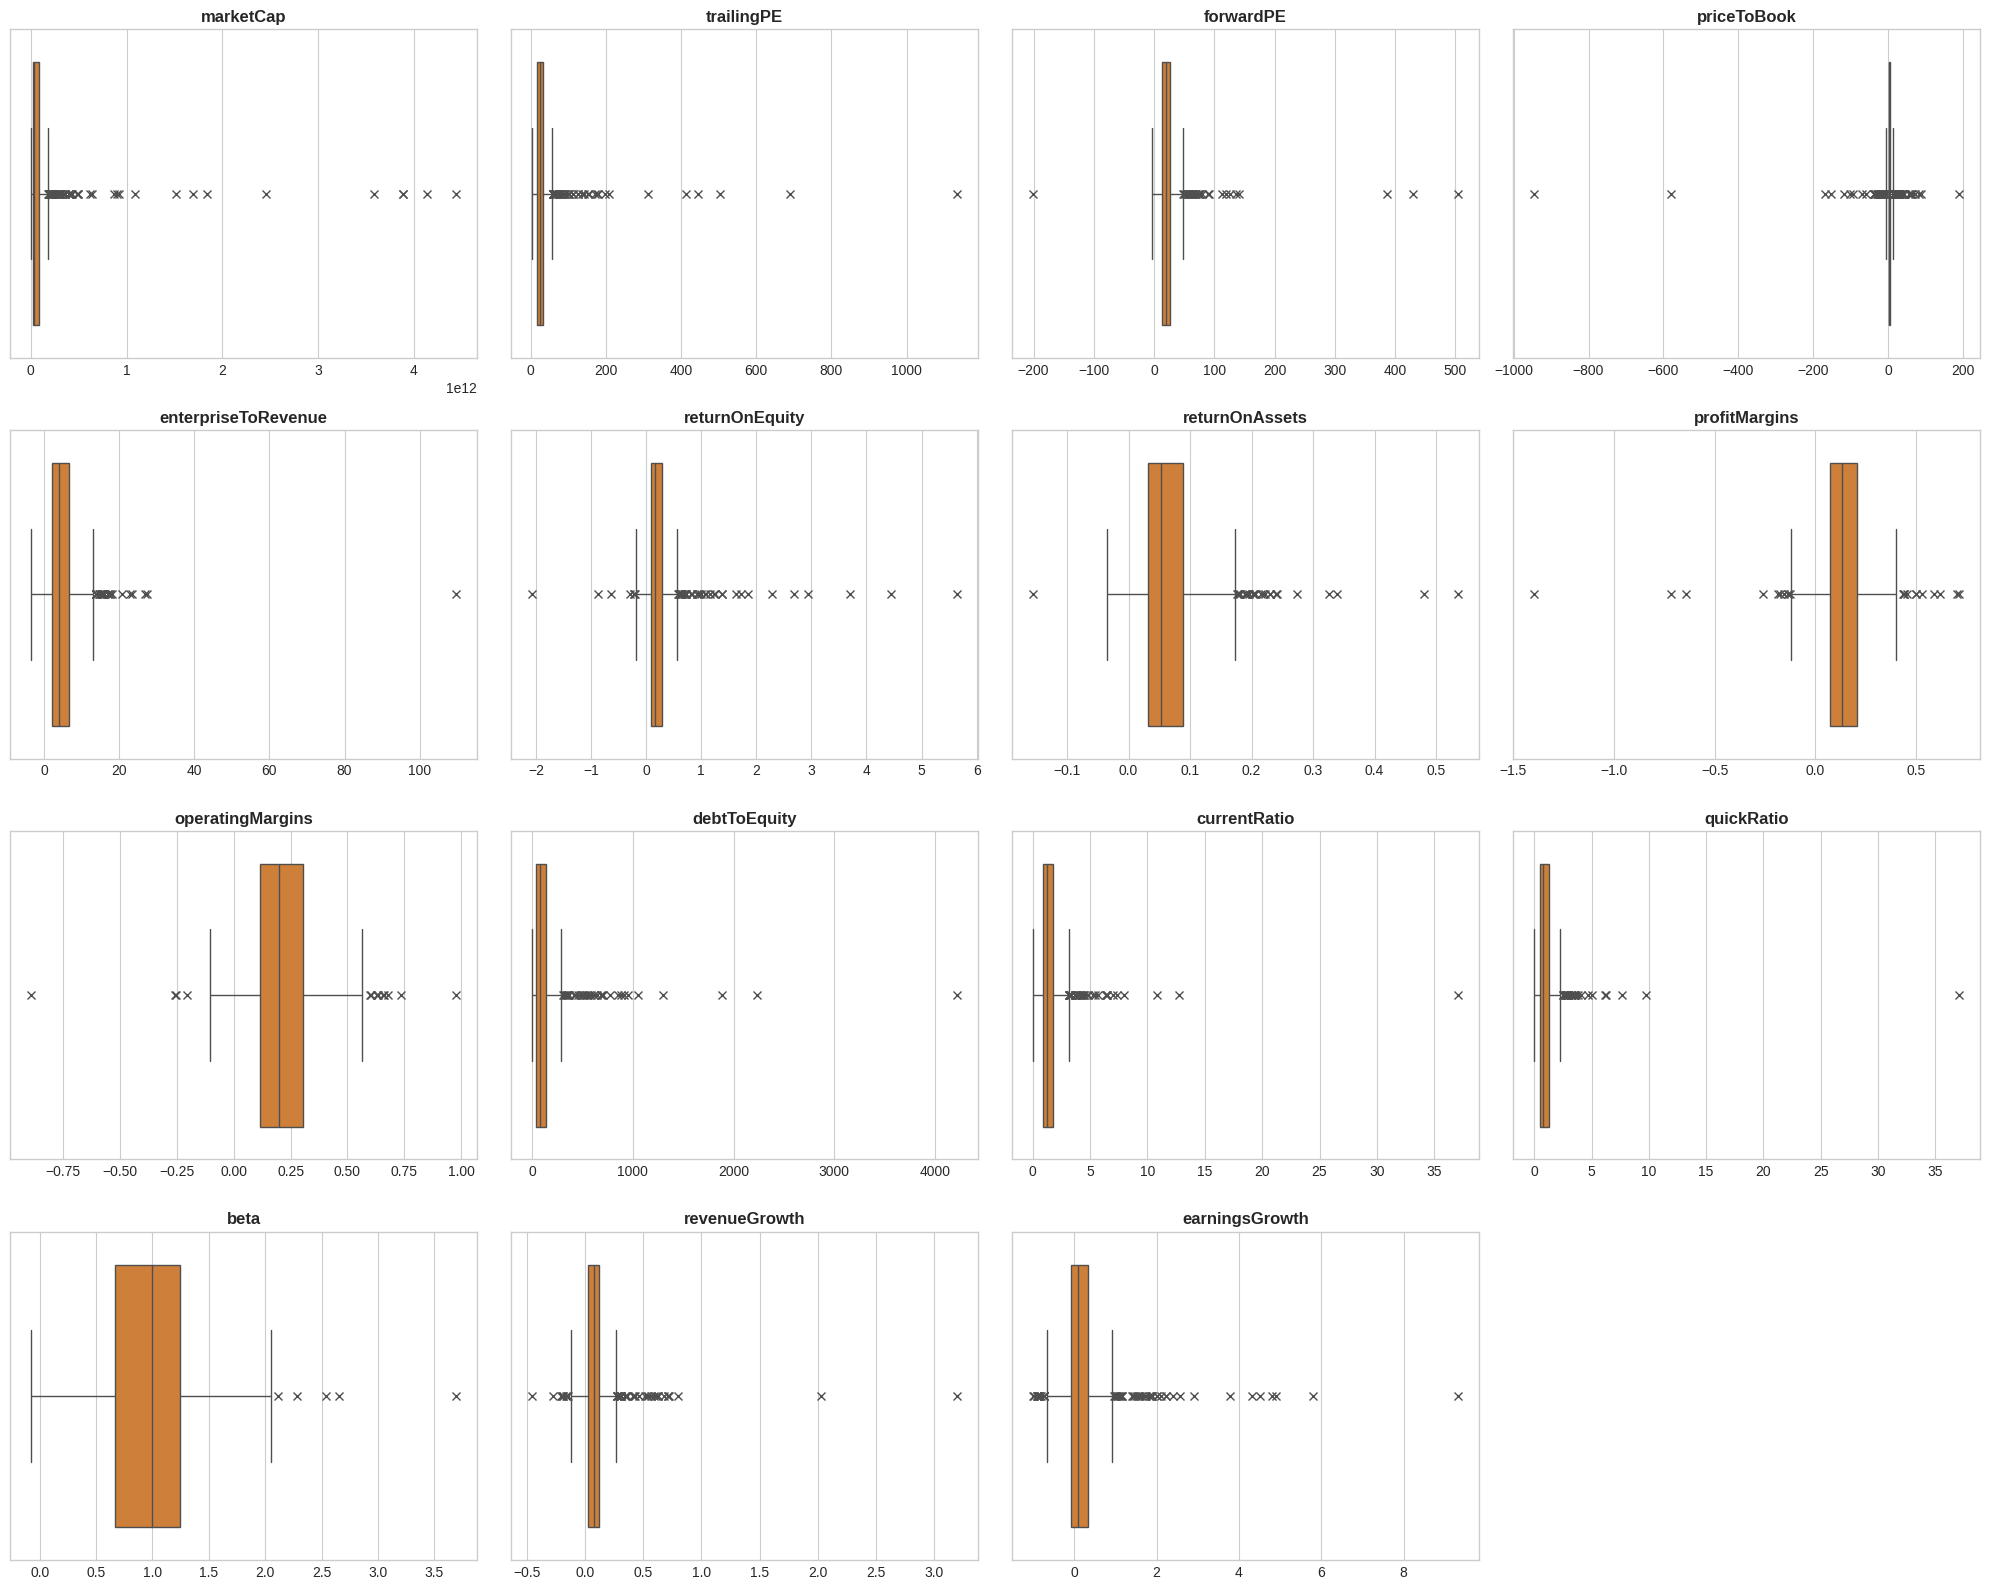


Kepadatan outlier:


,Jumlah Outlier,Persentase (%)
Fitur,,
priceToBook,86.00,17.13
marketCap,59.00,11.75
earningsGrowth,56.00,11.16
returnOnEquity,44.00,8.76
trailingPE,44.00,8.76
revenueGrowth,40.00,7.97
currentRatio,37.00,7.37
debtToEquity,37.00,7.37
forwardPE,34.00,6.77


In [9]:
# Metode IQR 1.5x

# 1. Visualisasi (Boxplot)
# Setup Grid visualisasi
n_cols = 4
n_rows = int(np.ceil(len(num_cols) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 16))
axs = axs.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df_eda[col], ax=axs[i], color='#e67e22', flierprops={"marker": "x"})
    axs[i].set_title(col, fontweight='bold')
    axs[i].set_xlabel('')

# Hapus subplot kosong
for j in range(i + 1, len(axs)): fig.delaxes(axs[j])
plt.tight_layout()
plt.show()


# 2. Analisis statistik (Ranking)
print("\nKepadatan outlier:")

outlier_stats = []

for col in num_cols:
    # Hitung IQR
    Q1 = df_eda[col].quantile(0.25)
    Q3 = df_eda[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Hitung Outlier
    n_outliers = ((df_eda[col] < lower_bound) | (df_eda[col] > upper_bound)).sum()
    pct_outliers = (n_outliers / len(df_eda)) * 100

    # Simpan ke list
    outlier_stats.append({
        'Fitur': col,
        'Jumlah Outlier': n_outliers,
        'Persentase (%)': pct_outliers
    })

# Buat DataFrame & Urutkan
outlier_df = pd.DataFrame(outlier_stats)
outlier_df = outlier_df.sort_values(by='Persentase (%)', ascending=False).set_index('Fitur')

# Tampilkan dengan Styling (Gradasi Warna Merah)
if not outlier_df.empty:
    display(outlier_df.style.background_gradient(cmap='Reds', subset=['Persentase (%)']).format("{:.2f}"))
else:
    print("Tidak ditemukan outlier yang signifikan")

## Correlation Heatmap

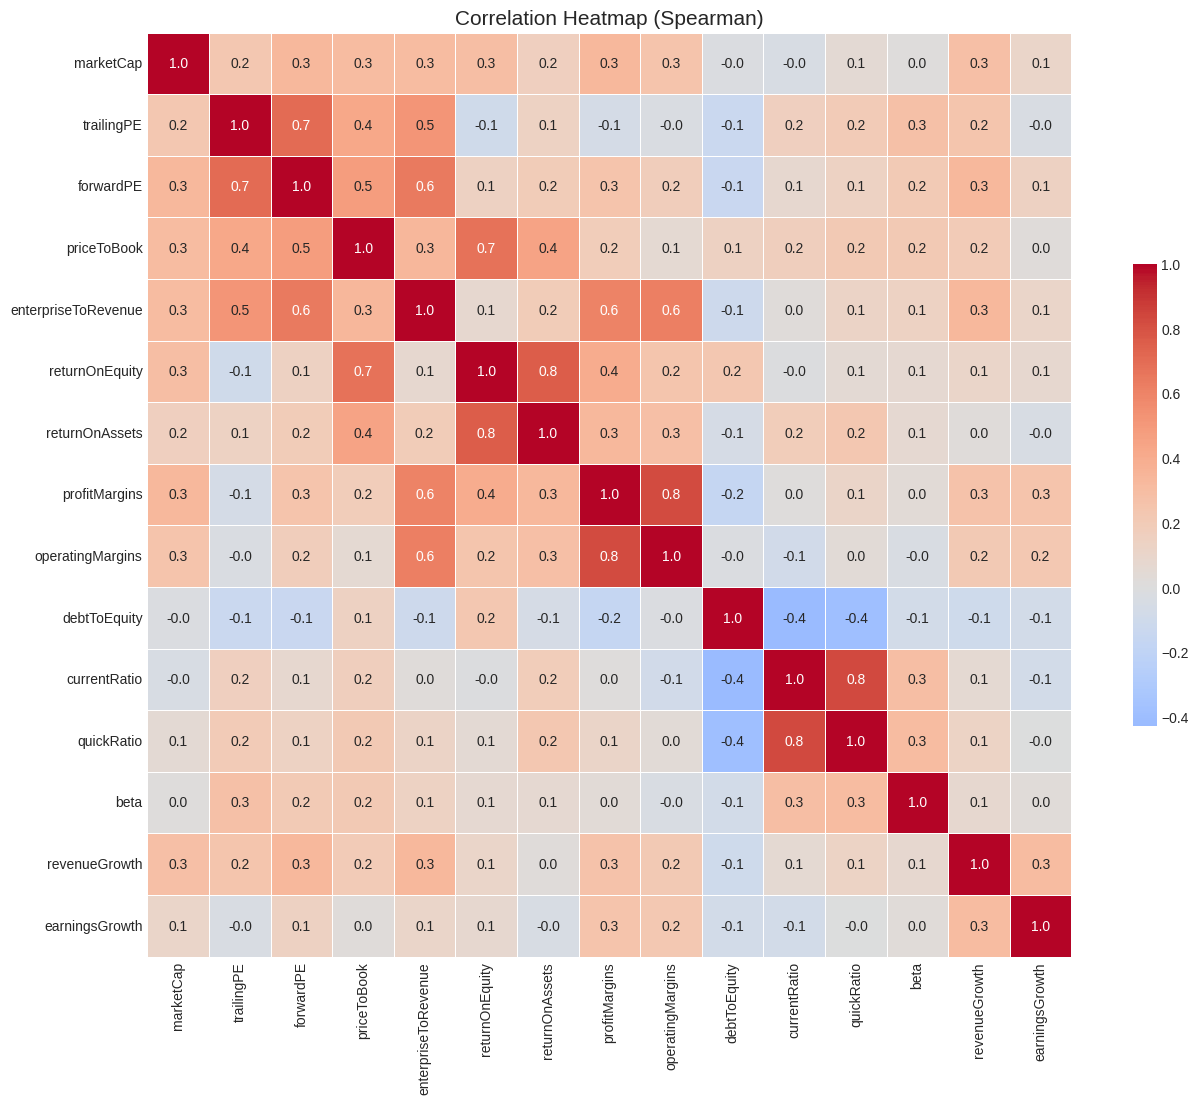

In [10]:
plt.figure(figsize=(16, 12))
corr = df_eda[num_cols].corr(method='spearman')

sns.heatmap(
    corr,
    annot=True,
    fmt=".1f",
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.5}
)
plt.title('Correlation Heatmap (Spearman)', fontsize=15)
plt.show()

# Preprocessing

In [11]:
# Preprocessing ini melakukan imputasi, log transform, winsorization, scaling, dan PCA
def preprocessing_pipeline(X_raw, sector_series, n_components=2, random_state=42):
    # 1. Copy data agar data asli tidak berubah
    X = X_raw.copy()

    # A. Sector-Aware Imputation
    # Hitung median per sektor
    medians = X.groupby(sector_series).median(numeric_only=True)

    for col in X.columns:
        # Isi NaN dengan median sektor, jika masih NaN (misal sektornya NaN) pakai median global
        if col in medians.columns:
            X[col] = X[col].fillna(sector_series.map(medians[col]))
        X[col] = X[col].fillna(X[col].median())

    # B. Log Transformation (Signed Log)
    cols_to_log = ['marketCap', 'enterpriseToRevenue']
    for col in cols_to_log:
        if col in X.columns:
            # Menggunakan np.sign * log1p(abs) agar aman untuk nilai negatif
            X[col] = np.sign(X[col]) * np.log1p(np.abs(X[col]))

    # C. Winsorization (1% - 99%)
    lower_bound = X.quantile(0.01)
    upper_bound = X.quantile(0.99)
    X = X.clip(lower=lower_bound, upper=upper_bound, axis=1)

    # D. Robust Scaling
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

    # E. PCA
    pca = PCA(n_components=n_components, random_state=random_state)
    X_pca = pca.fit_transform(X_scaled)

    return X_pca, pca, scaler

X = df[num_cols]
sectors = df['sector']

X_pca, pca_model, scaler_model = preprocessing_pipeline(
    X,
    sectors,
    n_components=2,
    random_state=42
)

print(f"PCA Explained Variance: {np.sum(pca_model.explained_variance_ratio_):.2%}")
print(f"Shape Awal : {X.shape}")
print(f"Shape Akhir: {X_pca.shape}")

PCA Explained Variance: 49.44%
Shape Awal : (502, 15)
Shape Akhir: (502, 2)


# PCA Evaluation

Variance Explained Analysis


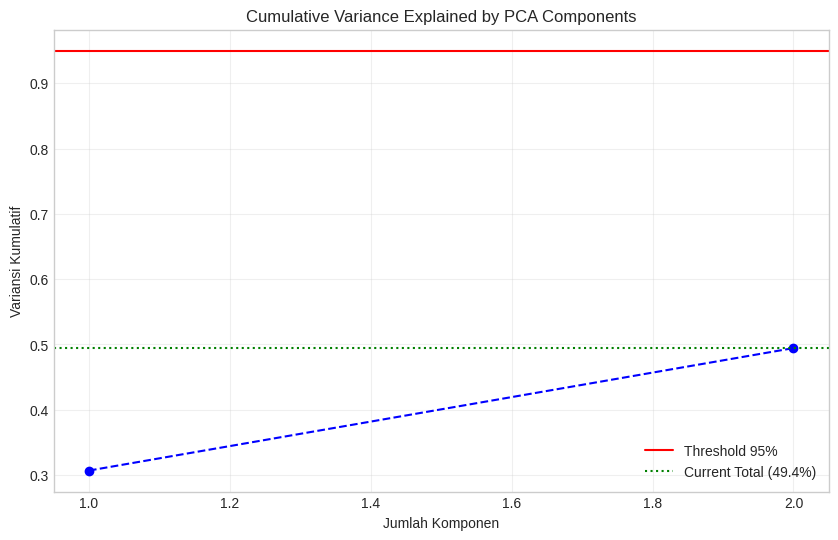

Total Variansi Tertangkap: 49.44%
Variansi per Komponen: [0.30687717 0.1875405 ]


In [12]:
# Variance Explained (Seberapa banyak informasi yang ditangkap)
print("Variance Explained Analysis")
exp_var = pca_model.explained_variance_ratio_
cum_var = np.cumsum(exp_var)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cum_var) + 1), cum_var, marker='o', linestyle='--', color='b')
plt.axhline(y=0.95, color='r', linestyle='-', label='Threshold 95%')
plt.axhline(y=cum_var[-1], color='g', linestyle=':', label=f'Current Total ({cum_var[-1]:.1%})')
plt.title('Cumulative Variance Explained by PCA Components')
plt.xlabel('Jumlah Komponen')
plt.ylabel('Variansi Kumulatif')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Total Variansi Tertangkap: {cum_var[-1]:.2%}")
print(f"Variansi per Komponen: {exp_var}")

Interpretasi Fitur (PCA Loadings)


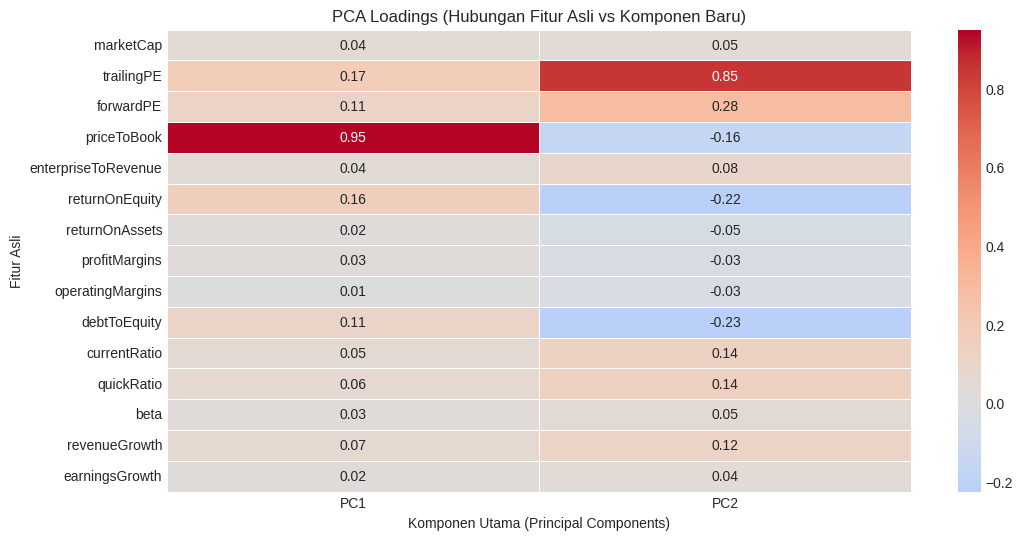

In [13]:
# PCA Loadings (Fitur apa yang paling berpengaruh?)
print("Interpretasi Fitur (PCA Loadings)")

loadings = pd.DataFrame(
    pca_model.components_,
    columns=num_cols,
    index=[f'PC{i+1}' for i in range(len(exp_var))]
)

# Visualisasi Heatmap (Tampilkan semua komponen yang ada)
plt.figure(figsize=(12, 6))
sns.heatmap(loadings.T, cmap='coolwarm', center=0, annot=True, fmt=".2f", linewidths=0.5)
plt.title('PCA Loadings (Hubungan Fitur Asli vs Komponen Baru)')
plt.xlabel('Komponen Utama (Principal Components)')
plt.ylabel('Fitur Asli')
plt.show()

Sebaran Data di Ruang PCA (PC1 vs PC2)


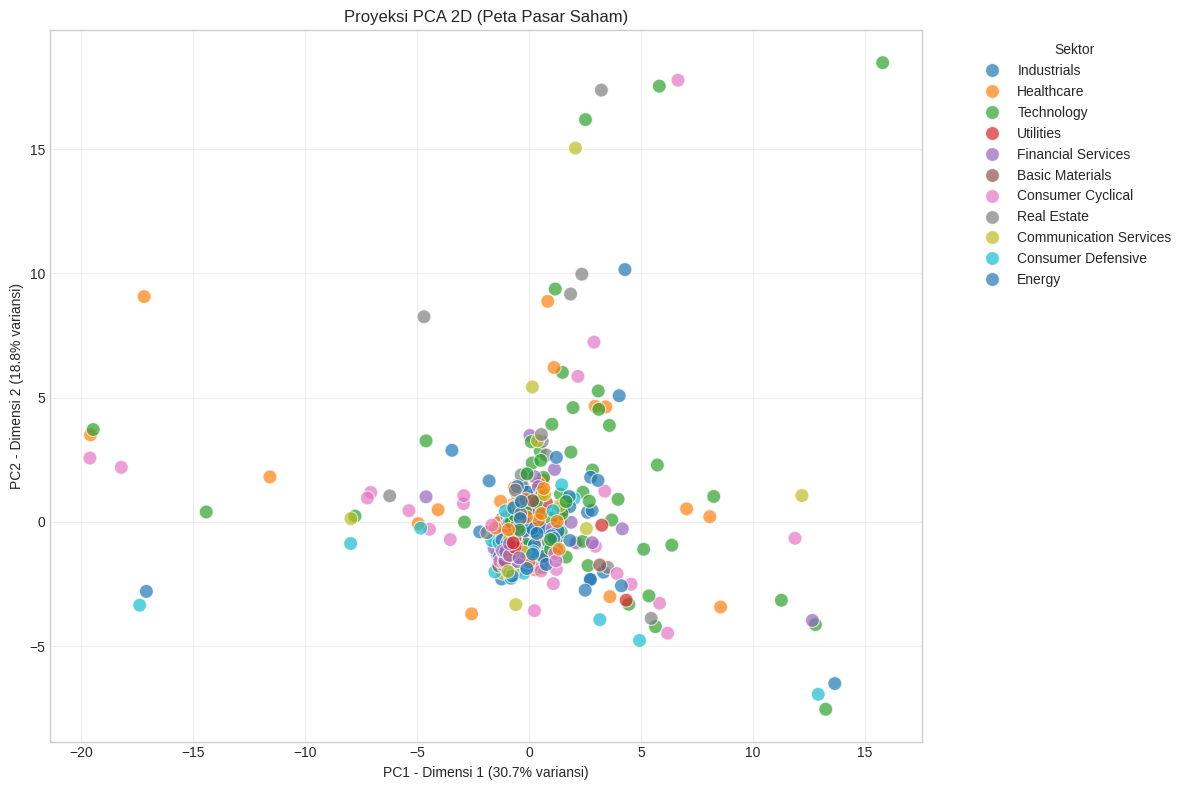

In [14]:
# Proyeksi Data 2D (Peta Sebaran)
# Hanya dijalankan jika memiliki minimal 2 komponen
if X_pca.shape[1] >= 2:
    print("Sebaran Data di Ruang PCA (PC1 vs PC2)")

    pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
    pca_df['Sector'] = sectors.values # Mengambil data sektor untuk warna

    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Sector', alpha=0.7, palette='tab10', s=100)

    plt.title('Proyeksi PCA 2D (Peta Pasar Saham)')
    plt.xlabel(f'PC1 - Dimensi 1 ({exp_var[0]:.1%} variansi)')
    plt.ylabel(f'PC2 - Dimensi 2 ({exp_var[1]:.1%} variansi)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Sektor')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Plot 2D dilewati karena jumlah komponen kurang dari 2")

# K-MEANS Validation

Validation Results:


,Silhouette Score,DBI Score
K,,
2,0.7589,0.5574
3,0.7108,0.6238
4,0.6854,0.6174
5,0.4757,0.7283
6,0.5688,0.6098
7,0.5973,0.6061
8,0.4362,0.6751
9,0.4278,0.7004
10,0.3930,0.7176


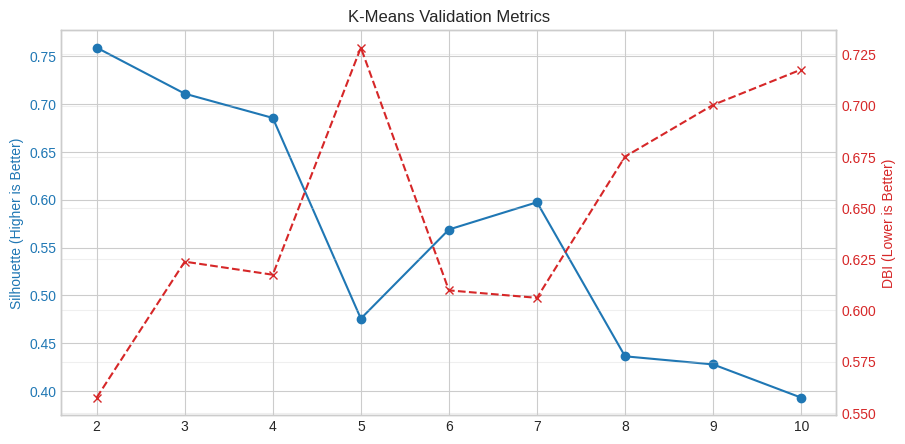

In [15]:
validation_data = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)

    sil = silhouette_score(X_pca, labels)
    dbi = davies_bouldin_score(X_pca, labels)

    validation_data.append({
        'K': k,
        'Silhouette Score': sil,
        'DBI Score': dbi
    })

# Display Results
df_validation = pd.DataFrame(validation_data).set_index('K')
print("Validation Results:")
display(df_validation.style.background_gradient(cmap='RdYlGn', subset=['Silhouette Score'])
                         .background_gradient(cmap='RdYlGn_r', subset=['DBI Score'])
                         .format("{:.4f}"))

# Plot Results
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(df_validation.index, df_validation['Silhouette Score'], marker='o', color='tab:blue', label='Silhouette')
ax1.set_ylabel('Silhouette (Higher is Better)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(df_validation.index, df_validation['DBI Score'], marker='x', linestyle='--', color='tab:red', label='DBI')
ax2.set_ylabel('DBI (Lower is Better)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('K-Means Validation Metrics')
plt.xlabel('Number of Clusters (K)')
plt.grid(True, alpha=0.3)
plt.show()

# K Choosing

In [16]:
FINAL_K = 3
print(f"DECISION: Using K={FINAL_K} (Strategic Choice)")

# Train Model
kmeans_final = KMeans(n_clusters=FINAL_K, random_state=42, n_init=50)
cluster_labels = kmeans_final.fit_predict(X_pca)
df['Cluster'] = cluster_labels

# Re-labeling Logic (Sort by ROE: 0=Low, 1=Mid, 2=High)
roe_median = df.groupby('Cluster')['returnOnEquity'].median().sort_values()
mapping = {old: new for new, old in enumerate(roe_median.index)}
df['Cluster'] = df['Cluster'].map(mapping)

# Calculate Centroids (New Labels)
centroids_pca = []
for i in sorted(df['Cluster'].unique()):
    centroids_pca.append(X_pca[df['Cluster'] == i].mean(axis=0))
centroids_pca = np.array(centroids_pca)

# Final Scores
print(f"Final Silhouette : {silhouette_score(X_pca, df['Cluster']):.4f}")
print(f"Final DBI        : {davies_bouldin_score(X_pca, df['Cluster']):.4f}")

DECISION: Using K=3 (Strategic Choice)
Final Silhouette : 0.7108
Final DBI        : 0.6238


# Cluster Analysis & Investment Strategy

In [17]:
print("Cluster Analysis & Investment Strategy:")

# RE-LABELING LOGIC
# Mengurutkan cluster berdasarkan ROE (0 = Terendah, 2 = Tertinggi)
# Ini MEMASTIKAN bahwa Cluster 0 selalu yang "Growth/Low ROE" dan Cluster 2 yang "Aggressive"
roe_median = df.groupby('Cluster')['returnOnEquity'].median().sort_values()
mapping = {old: new for new, old in enumerate(roe_median.index)}
df['Cluster'] = df['Cluster'].map(mapping)
print(f"Cluster telah diurutkan ulang berdasarkan ROE: {mapping}")

# Pilih kolom untuk laporan (Pastikan kolom ada)
report_cols = ['marketCap', 'returnOnEquity', 'debtToEquity', 'revenueGrowth', 'forwardPE']
valid_report_cols = [c for c in report_cols if c in df.columns]

# Hitung Median (Data yang sudah diurutkan)
cluster_profile = df.groupby('Cluster')[valid_report_cols].median()
cluster_profile['Count'] = df['Cluster'].value_counts()

# Siapkan Data Laporan
analysis_data = []

for i in sorted(cluster_profile.index):
    count = cluster_profile.loc[i, 'Count']
    roe = cluster_profile.loc[i, 'returnOnEquity']
    debt = cluster_profile.loc[i, 'debtToEquity']
    pe = cluster_profile.loc[i, 'forwardPE'] if 'forwardPE' in cluster_profile.columns else 0

    # Logika Bisnis

    # 1. Cluster 2: High Risk High Return (Pasti ROE Tertinggi karena sudah disortir)
    if debt > 200 and roe > 0.40:
        profile = "Struktur Modal Agresif (High Leverage)"
        strategy = "STRATEGI: Spekulatif. Efisiensi ekstrem via utang. Pantau likuiditas ketat."

    # 2. Cluster 0: High Growth / High Valuation
    # Karena sudah disortir, kita aman menggunakan logika (i == 0) untuk ROE terendah
    elif pe > 40 or (i == 0):
        profile = "High Growth / Overvalued (Expansive)"
        strategy = "STRATEGI: Growth Investing. Mahal (PE Tinggi) karena pertumbuhan omzet tinggi. Risiko volatilitas."

    # 3. Cluster 1: Quality / Value (Tengah-tengah)
    elif roe > 0.10 and debt < 150:
        profile = "Fundamental Prima (Quality Leaders)"
        strategy = "STRATEGI: Core Portfolio (Buy). Keseimbangan profitabilitas & stabilitas."

    # 4. Sisanya
    else:
        profile = "Kualitas Rendah (Laggards)"
        strategy = "STRATEGI: Hindari (Avoid). Fundamental lemah tanpa prospek pertumbuhan."

    analysis_data.append({
        'Cluster': i,
        'Populasi': int(count),
        'ROE (%)': f"{roe:.1%}",
        'Debt (%)': f"{debt:.0f}%",
        'PE (x)': f"{pe:.1f}x",
        'Profil Perusahaan': profile,
        'Rekomendasi Strategi': strategy
    })

# Tampilkan Laporan DataFrame
df_report = pd.DataFrame(analysis_data)
styled_report = df_report.style.hide(axis='index').set_properties(**{
    'text-align': 'left', 'vertical-align': 'top', 'white-space': 'pre-wrap',
    'border': '1px solid #bdc3c7', 'padding': '12px', 'font-size': '11pt'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#2c3e50'), ('color', 'white'), ('text-align', 'center'), ('padding', '12px')]},
    {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]}
])
display(styled_report)

# Tampilkan Heatmap Angka
print("\nData Profile:")
display(cluster_profile.style.background_gradient(cmap='RdYlGn', subset=['returnOnEquity'])
                        .background_gradient(cmap='RdYlGn_r', subset=['debtToEquity', 'forwardPE'])
                        .format("{:.2f}"))

Cluster Analysis & Investment Strategy:
Cluster telah diurutkan ulang berdasarkan ROE: {0: 0, 1: 1, 2: 2}


Cluster,Populasi,ROE (%),Debt (%),PE (x),Profil Perusahaan,Rekomendasi Strategi
0,25,8.4%,46%,57.6x,High Growth / Overvalued (Expansive),STRATEGI: Growth Investing. Mahal (PE Tinggi) karena pertumbuhan omzet tinggi. Risiko volatilitas.
1,468,15.6%,76%,19.5x,Fundamental Prima (Quality Leaders),STRATEGI: Core Portfolio (Buy). Keseimbangan profitabilitas & stabilitas.
2,9,443.6%,2060%,18.6x,Struktur Modal Agresif (High Leverage),STRATEGI: Spekulatif. Efisiensi ekstrem via utang. Pantau likuiditas ketat.



Data Profile:


,marketCap,returnOnEquity,debtToEquity,revenueGrowth,forwardPE,Count
Cluster,,,,,,
0,91973541888.00,0.08,46.21,0.16,57.57,25.00
1,37567807488.00,0.16,75.69,0.07,19.48,468.00
2,60740550656.00,4.44,2059.56,0.08,18.64,9.00


# Visualization

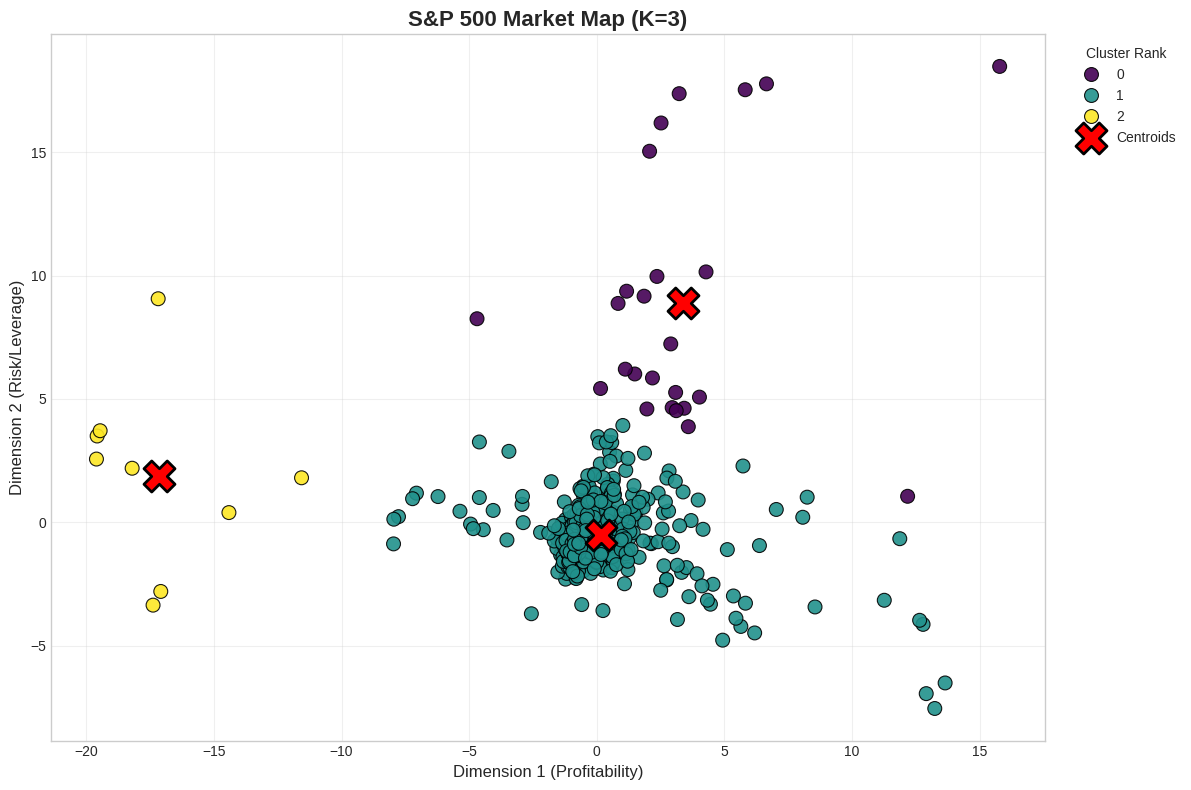

In [18]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='viridis', s=100, alpha=0.9, edgecolor='k')
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=500, c='red', marker='X', label='Centroids', edgecolor='black', linewidth=2)

plt.title(f'S&P 500 Market Map (K={FINAL_K})', fontsize=16, fontweight='bold')
plt.xlabel('Dimension 1 (Profitability)', fontsize=12)
plt.ylabel('Dimension 2 (Risk/Leverage)', fontsize=12)
plt.legend(title='Cluster Rank', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Export Data Cluster

In [19]:
output_csv = 'sp500_ratio_cluster.csv'

df.to_csv(output_csv, index=False)

print(f"Data diekspor ke: {output_csv}")
print(f"Jumlah Baris : {len(df)}")
print(f"Jumlah Kolom : {len(df.columns)}")

Data diekspor ke: sp500_ratio_cluster.csv
Jumlah Baris : 502
Jumlah Kolom : 18


# Export Model

In [20]:
# Membuat Dictionary Artifacts
model_artifacts = {
    'scaler': scaler_model,        # Normalisasi data baru
    'pca': pca_model,              # Reduksi dimensi data baru
    'kmeans': kmeans_final,        # Prediksi cluster
    'features': num_cols,          # Daftar kolom input yang harus ada
    'n_components': 2,             # Metadata: Jumlah komponen PCA yang dipakai
    'cluster_mapping': {           # Metadata: Arti dari setiap angka cluster
        0: "High Growth / Overvalued",
        1: "Fundamental Prima (Quality)",
        2: "Struktur Modal Agresif"
    }
}

output_model = 'sp500_ratio_cluster.joblib'

joblib.dump(model_artifacts, output_model)

print(f"Model Pipeline diekspor ke: {output_model}")
print("Isi Artifacts:")
for key, value in model_artifacts.items():
    print(f"{key}: {type(value)}")

Model Pipeline diekspor ke: sp500_ratio_cluster.joblib
Isi Artifacts:
scaler: <class 'sklearn.preprocessing._data.RobustScaler'>
pca: <class 'sklearn.decomposition._pca.PCA'>
kmeans: <class 'sklearn.cluster._kmeans.KMeans'>
features: <class 'list'>
n_components: <class 'int'>
cluster_mapping: <class 'dict'>
